# Use a pre-trained UNet to predict the attention masks

The UNet is trained with the 8 hours of training data

In [61]:
from network.models.building_blocks.u2net import U2NET
import torch

unet = U2NET(3, 1)

# load pretrained model
unet.load_state_dict(torch.load('./network/saved_models/u2net/u2net_bce_town01_8hrdata.pth'))
unet.eval()

<All keys matched successfully>

In [34]:
# Get the number of parameters
total_params = sum(p.numel() for p in unet.parameters())
print(f'{total_params:,} total parameters.')

44,009,869 total parameters.


In [62]:
import numpy as np
from skimage import io, transform, color

class RescaleT(object):

	def __init__(self,output_size):
		assert isinstance(output_size,(int,tuple))
		self.output_size = output_size

	def __call__(self, image):

		h, w = image.shape[:2]
		# print("lbl_before :", np.unique(label))
		if isinstance(self.output_size,int):
			if h > w:
				new_h, new_w = self.output_size*h/w,self.output_size
			else:
				new_h, new_w = self.output_size,self.output_size*w/h
		else:
			new_h, new_w = self.output_size

		new_h, new_w = int(new_h), int(new_w)

		# #resize the image to new_h x new_w and convert image from range [0,255] to [0,1]
		img = transform.resize(image,(self.output_size,self.output_size),
						 mode='constant')

		return img

class ToTensorLab(object):
	"""Convert ndarrays in sample to Tensors."""
	def __init__(self):
		pass

	def __call__(self, image):
		# with rgb color
		tmpImg = np.zeros((image.shape[0],image.shape[1],3))
		image = image / np.max(image)
		if image.shape[2]==1:
			# Grayscale
			tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
			tmpImg[:,:,1] = (image[:,:,0]-0.485)/0.229
			tmpImg[:,:,2] = (image[:,:,0]-0.485)/0.229
		else:
			# RGB
			tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
			tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
			tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225

		tmpImg = tmpImg.transpose((2, 0, 1))

		return torch.from_numpy(tmpImg)
	
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn


In [63]:
from PIL import Image
from torchvision import transforms

t = transforms.Compose([
    RescaleT(320),
    ToTensorLab()
])

In [64]:
from skimage import io

test_img =  io.imread('./test_data/attention_t01_route00_clearnoon/rgb_central000517.png')

test_img.shape

(640, 640, 3)

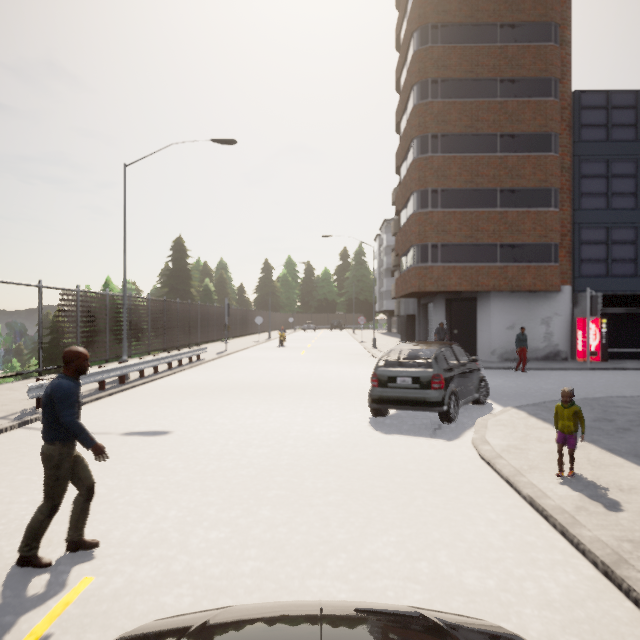

In [65]:
Image.fromarray(test_img)

In [66]:
# type(test_img) -> numpy.ndarray
# test_img.dtype -> dtype('uint8'), so 0 to 255
# t(test_img).shape -> torch.Size([3, 320, 320])
# t(test_img).dtype -> torch.float64

In [74]:
tr_test_img = t(test_img).unsqueeze(0)


tr_test_img = tr_test_img.type(torch.FloatTensor)
tr_test_img = torch.autograd.Variable(tr_test_img)

pred, *_ = unet(tr_test_img)

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [76]:
pred = pred.squeeze()
pred = normPRED(pred)

In [93]:
# pred = pred.squeeze()
pred_np = pred.squeeze().cpu().data.numpy()
pred_np = (pred_np*255).astype(np.uint8)
out = Image.fromarray(pred_np, 'L')

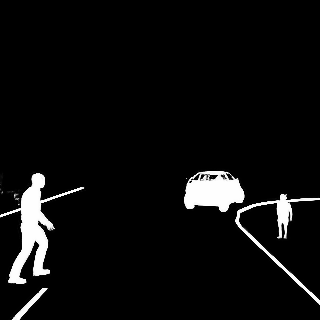

In [94]:
out

In [97]:
test_img =  io.imread('./test_data/attention_t01_route00_clearnoon/rgb_central000517.png')
test_img = Image.fromarray(test_img)
test_img = t2(test_img).unsqueeze(0)

test_img.shape

torch.Size([1, 3, 320, 320])

In [107]:
tr_pt = transforms.Compose([
    transforms.Resize(320),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

masks = {'resized_rgb_central': None, 'resized_rgb_left': None, 'resized_rgb_right': None,
         'rgb_central': None, 'rgb_left': None, 'rgb_right': None}
idx = 517

for name in masks.keys():
    test_img = io.imread(f'./test_data/attention_t01_route00_clearnoon/{name}{idx:06d}.png')
    test_img = Image.fromarray(test_img)
    test_img = tr_pt(test_img).unsqueeze(0)
    test_img = test_img.type(torch.FloatTensor)
    test_img = torch.autograd.Variable(test_img)

    pred, *_ = unet(test_img)
    pred = pred[:, 0, :, :]
    pred = normPRED(pred)

    pred_np = pred.squeeze().cpu().data.numpy()
    pred_np = (pred_np*255).astype(np.uint8)

    out = Image.fromarray(pred_np, 'L')
    masks[name] = pred_np

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


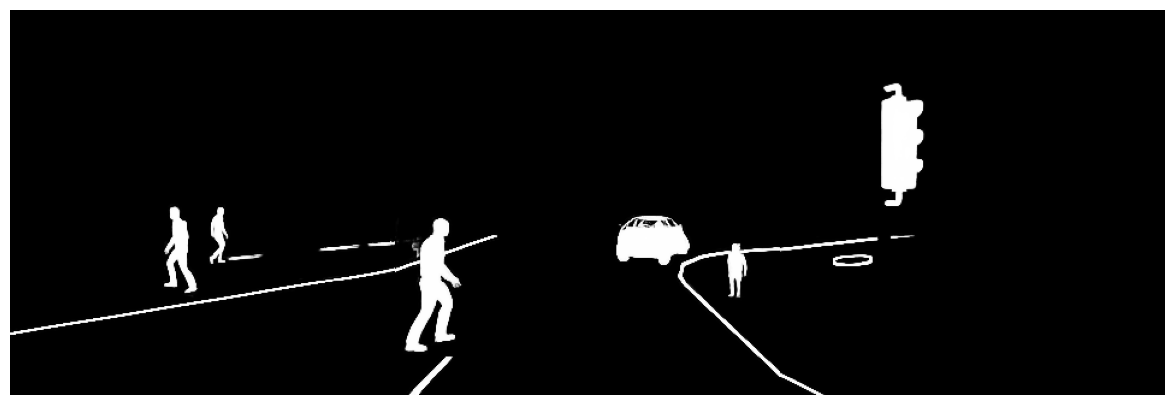

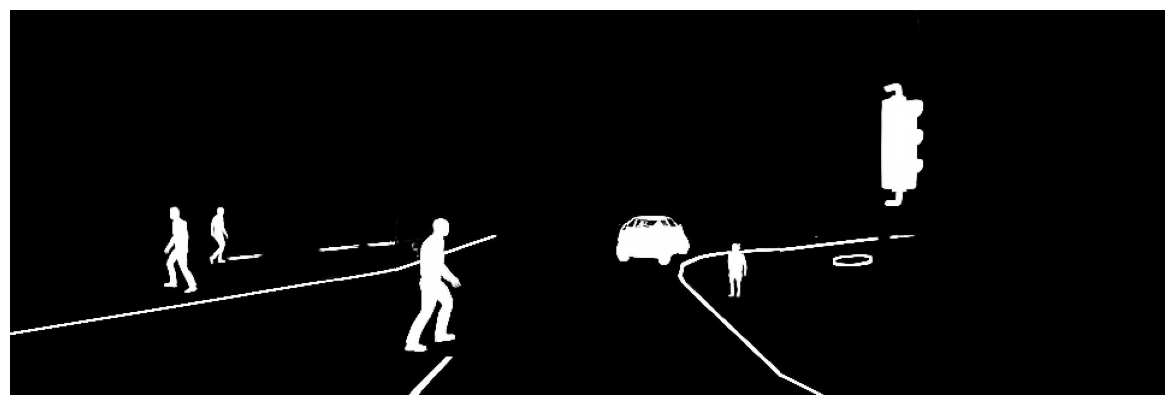

In [117]:
# Horizontally concatenate the three masks and display them
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
resized_mask = np.concatenate((masks['resized_rgb_left'], masks['resized_rgb_central'], masks['resized_rgb_right']), axis=1)
ax.imshow(resized_mask, cmap='gray')
ax.set_axis_off()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(15, 5))
fullres_mask = np.concatenate((masks['rgb_left'], masks['rgb_central'], masks['rgb_right']), axis=1)
ax.imshow(fullres_mask, cmap='gray')
ax.set_axis_off()
plt.show()

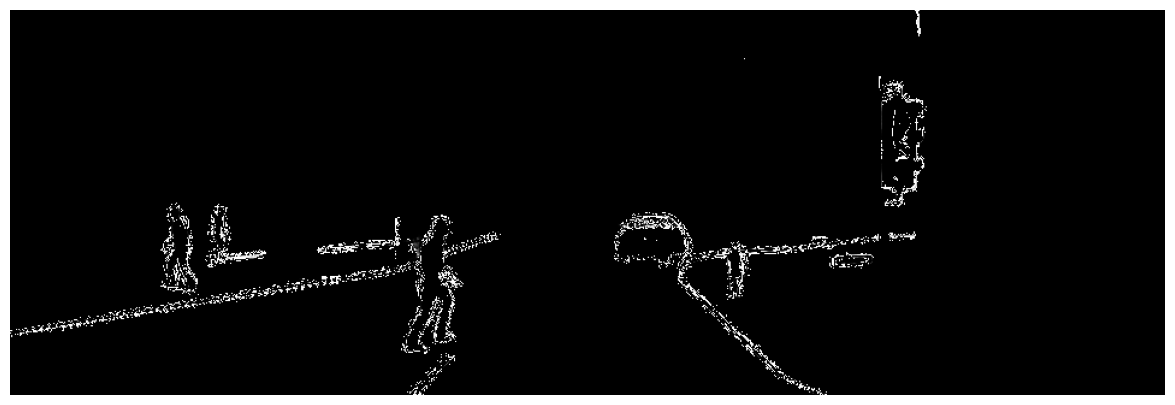

In [118]:
# Get the differences in both concatenated images
diff = np.abs(resized_mask - fullres_mask)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(diff, cmap='gray')
ax.set_axis_off()
plt.show()


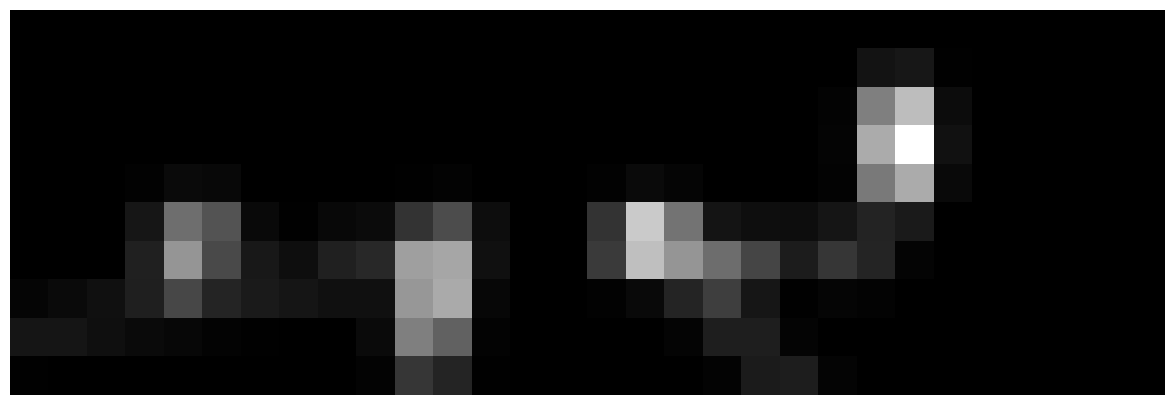

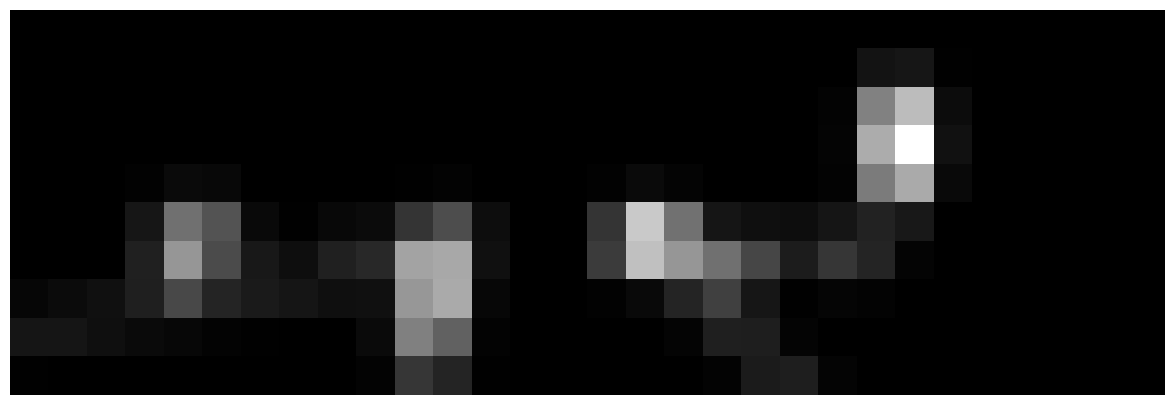

In [119]:
# Resize the fullres mask to 30x10
resized_fullres_mask = transform.resize(fullres_mask, (10, 30), mode='constant')
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(resized_fullres_mask, cmap='gray')
ax.set_axis_off()
plt.show()

resized_resized_mask = transform.resize(resized_mask, (10, 30), mode='constant')
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(resized_resized_mask, cmap='gray')
ax.set_axis_off()
plt.show()

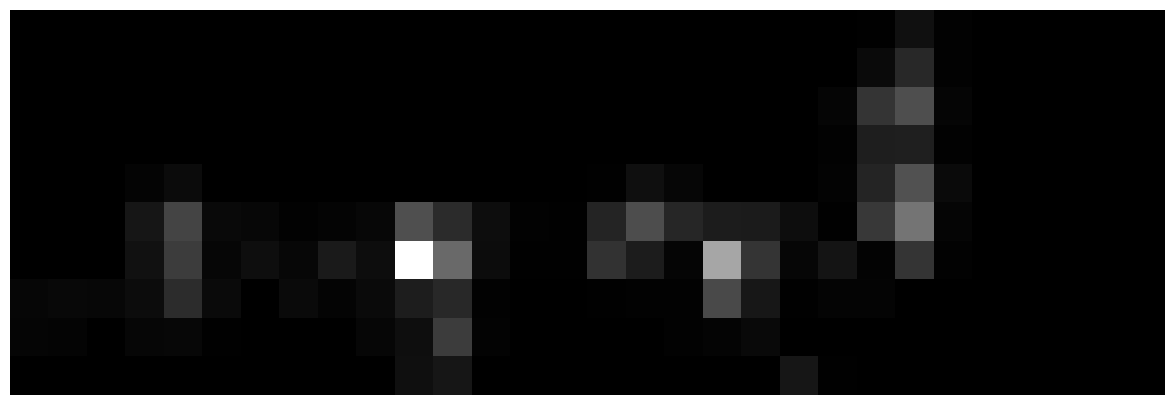

In [120]:
# What are the differences at this resolution?
diff = np.abs(resized_resized_mask - resized_fullres_mask)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(diff, cmap='gray')
ax.set_axis_off()
plt.show()

## Use the original transformations

In [122]:
tr = transforms.Compose([
    RescaleT(320),
    ToTensorLab()
])

correct_masks = {
    'resized_rgb_central': None, 'resized_rgb_left': None, 'resized_rgb_right': None,
    'rgb_central': None, 'rgb_left': None, 'rgb_right': None}
idx = 517

for name in correct_masks.keys():
    test_img = io.imread(f'./test_data/attention_t01_route00_clearnoon/{name}{idx:06d}.png')
    test_img = tr(test_img).unsqueeze(0)
    test_img = test_img.type(torch.FloatTensor)
    test_img = torch.autograd.Variable(test_img)

    pred, *_ = unet(test_img)
    pred = pred[:, 0, :, :]
    pred = normPRED(pred)

    pred_np = pred.squeeze().cpu().data.numpy()
    pred_np = (pred_np*255).astype(np.uint8)

    out = Image.fromarray(pred_np, 'L')
    correct_masks[name] = pred_np

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


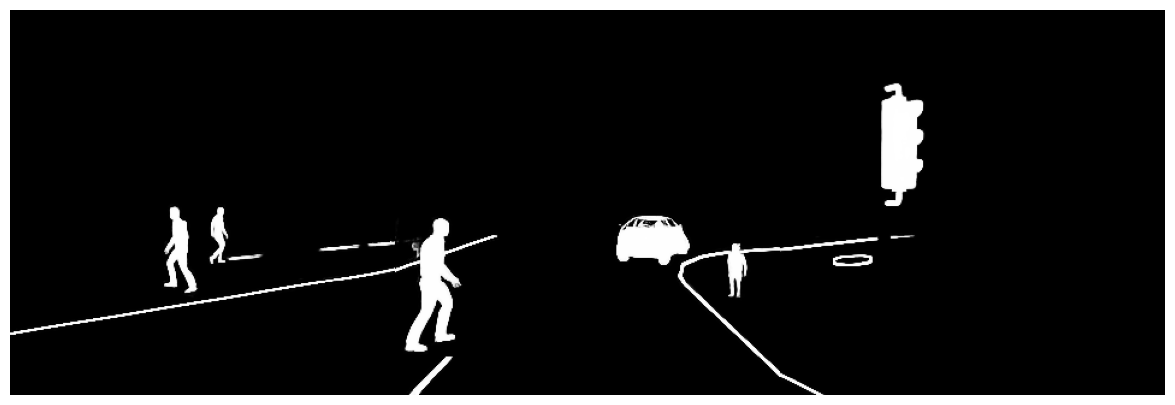

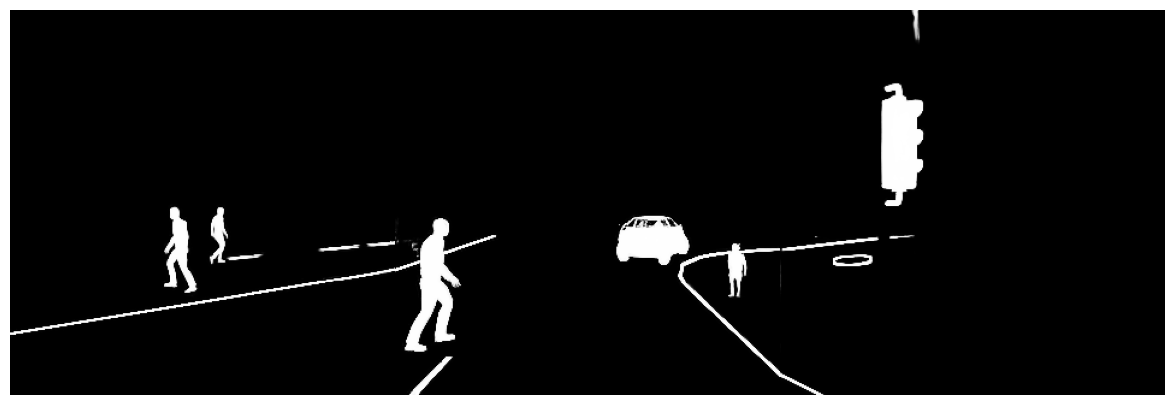

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
corect_resized_mask = np.concatenate((correct_masks['resized_rgb_left'], correct_masks['resized_rgb_central'], correct_masks['resized_rgb_right']), axis=1)
ax.imshow(corect_resized_mask, cmap='gray')
ax.set_axis_off()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(15, 5))
correct_fullres_mask = np.concatenate((correct_masks['rgb_left'], correct_masks['rgb_central'], correct_masks['rgb_right']), axis=1)
ax.imshow(correct_fullres_mask, cmap='gray')
ax.set_axis_off()
plt.show()

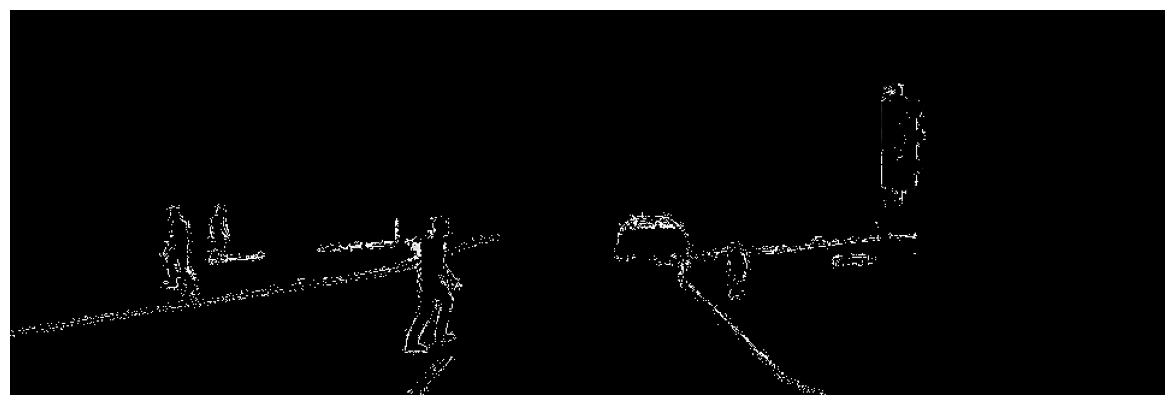

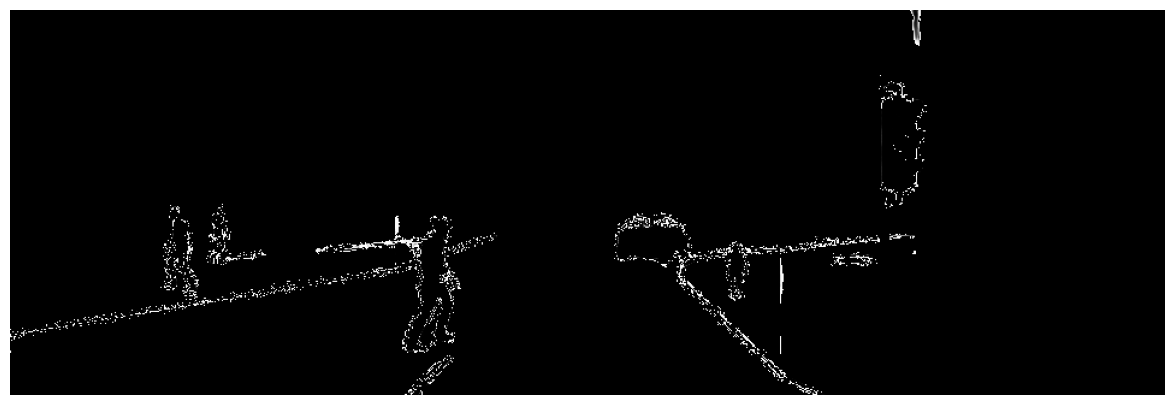

In [124]:
# Now see the differences with the correct masks
diff = np.abs(resized_mask - corect_resized_mask)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(diff, cmap='gray')
ax.set_axis_off()
plt.show()

diff = np.abs(fullres_mask - correct_fullres_mask)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.imshow(diff, cmap='gray')
ax.set_axis_off()
plt.show()